# Lab 5. MLP MNIST classification (2)

### 이번 실습은 저번 4주차 MLP MNIST classification에 이어 5주차 이론에서 배운 학습 방법들을 적용해 모델을 학습시켜 봅니다.

### 다양한 MNIST dataset을 torchvision에서 load 하여 classification을 진행하며, torch에서 지원하는 여러 종류의 optimizer, lr scheduler, 그리고 regularization 기법들을 적용해 봅니다.

### MLP의 구조, optimizer, scheduler의 종류와 다른 기법에 따른 학습 속도와 성능 변화를 비교해보고 dropout과 batch normalization이 어떠한 효과를 가지는 지 실험을 하며 비교해 봅니다.

### 이번 실습에서 사용할 패키지들은 다음과 같습니다.

- os
- numpy
- pytorch
- torchvision
- matplotlib


### Drive mount and package import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 5-1. Data Prepare

In [4]:
root = os.path.join(os.getcwd(), "drive", "MyDrive", "Colab Notebooks", "data")
root

'/content/drive/MyDrive/Colab Notebooks/data'

### 5-1-1. MNIST

In [5]:
mnist_train = datasets.MNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
sample_x, sample_y = mnist_train[0]
print(sample_x.shape)
print(sample_y)

torch.Size([1, 28, 28])
5


In [8]:
mnist_train.targets.shape, mnist_train.targets.unique()

(torch.Size([60000]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [9]:
def plot_mnist(data, figsize=(20, 10)):
  fig = plt.figure(figsize=figsize)
  for i in range(18):
    img = data[i][0]
    ax = fig.add_subplot(3, 6, i+1)
    ax.imshow(img.reshape(28, 28), cmap="gray")
    ax.set_title(f"Label: {data[i][1]}")
  fig.show()
  pass

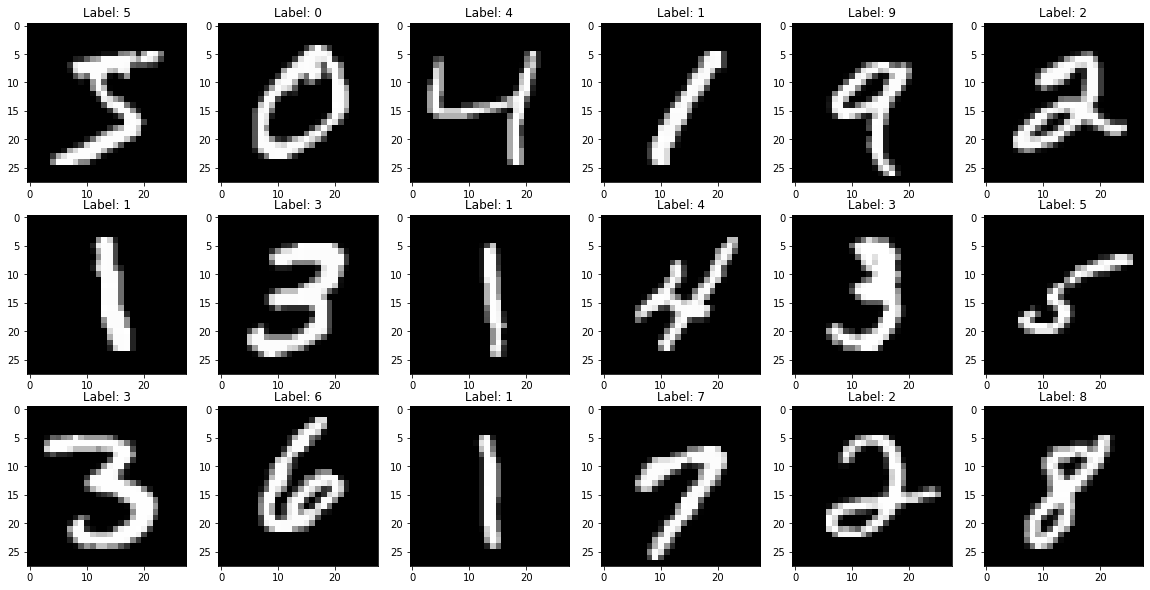

In [10]:
plot_mnist(data=mnist_train)

### 5-1-2. Fashion MNIST

In [11]:
fmnist_train = datasets.FashionMNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
fmnist_test = datasets.FashionMNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

In [12]:
fmnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
fmnist_train.targets.shape, fmnist_train.targets.unique()

(torch.Size([60000]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

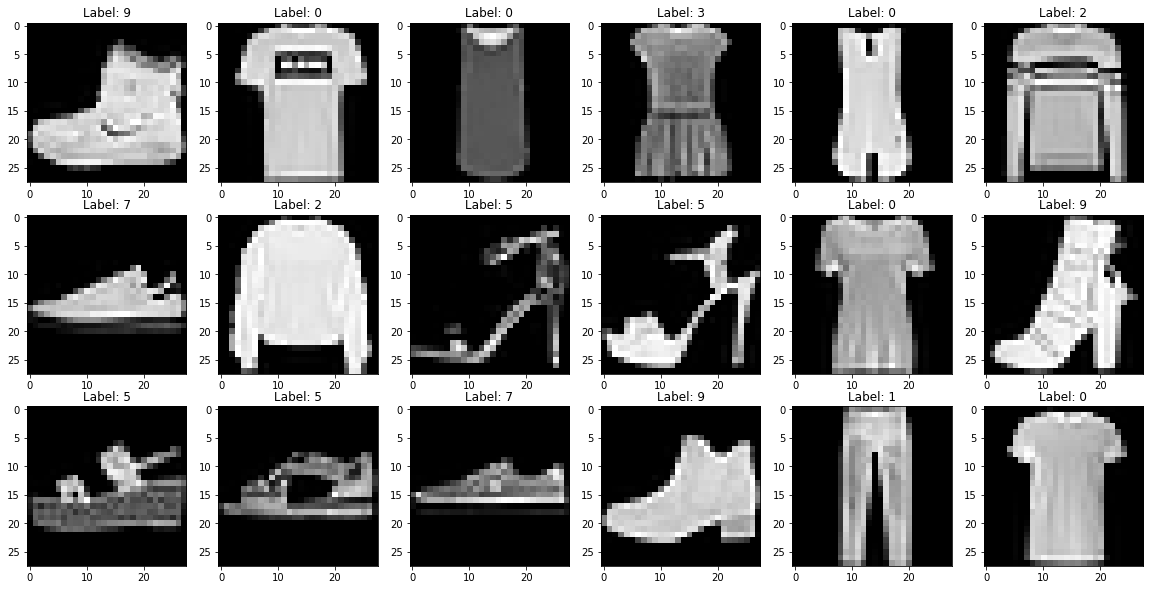

In [14]:
plot_mnist(data=fmnist_train)

### 5-1-3. KMNIST

In [15]:
kmnist_train = datasets.KMNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
kmnist_test = datasets.KMNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

In [16]:
kmnist_train

Dataset KMNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [17]:
kmnist_train.targets.shape, kmnist_train.targets.unique()

(torch.Size([60000]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

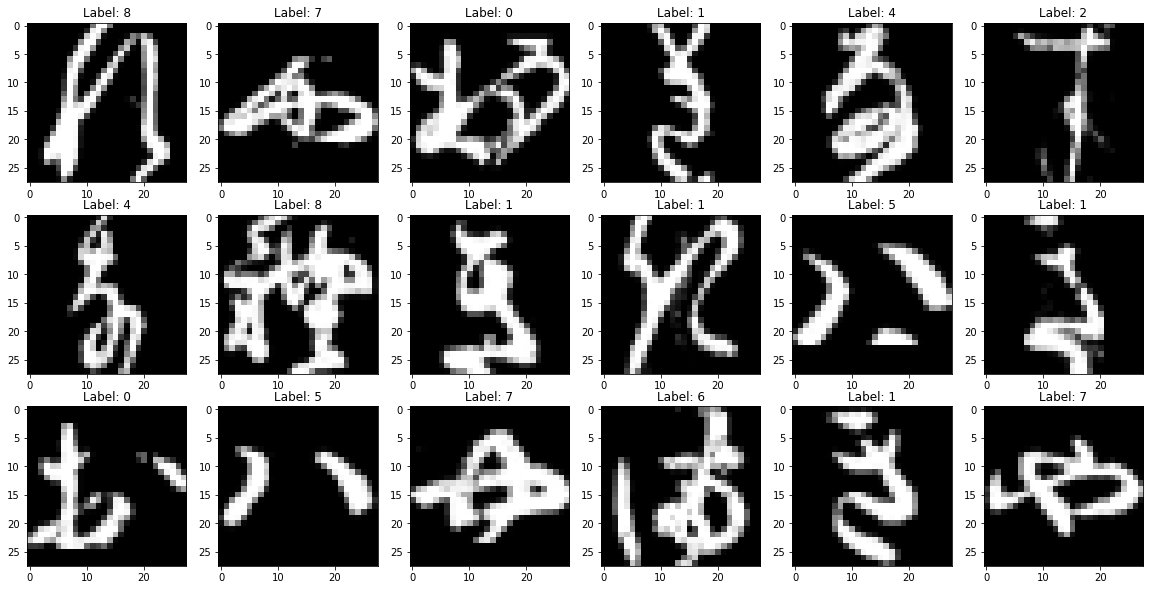

In [18]:
plot_mnist(data=kmnist_train)

### 5-1-4. EMNIST

In [19]:
emnist_train = datasets.EMNIST(
    root=root,
    split="byclass",
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
emnist_test = datasets.EMNIST(
    root=root,
    split="byclass",
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

In [20]:
emnist_train

Dataset EMNIST
    Number of datapoints: 697932
    Root location: /content/drive/MyDrive/Colab Notebooks/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [21]:
emnist_train.targets.shape, emnist_train.targets.unique()

(torch.Size([697932]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
         36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61]))

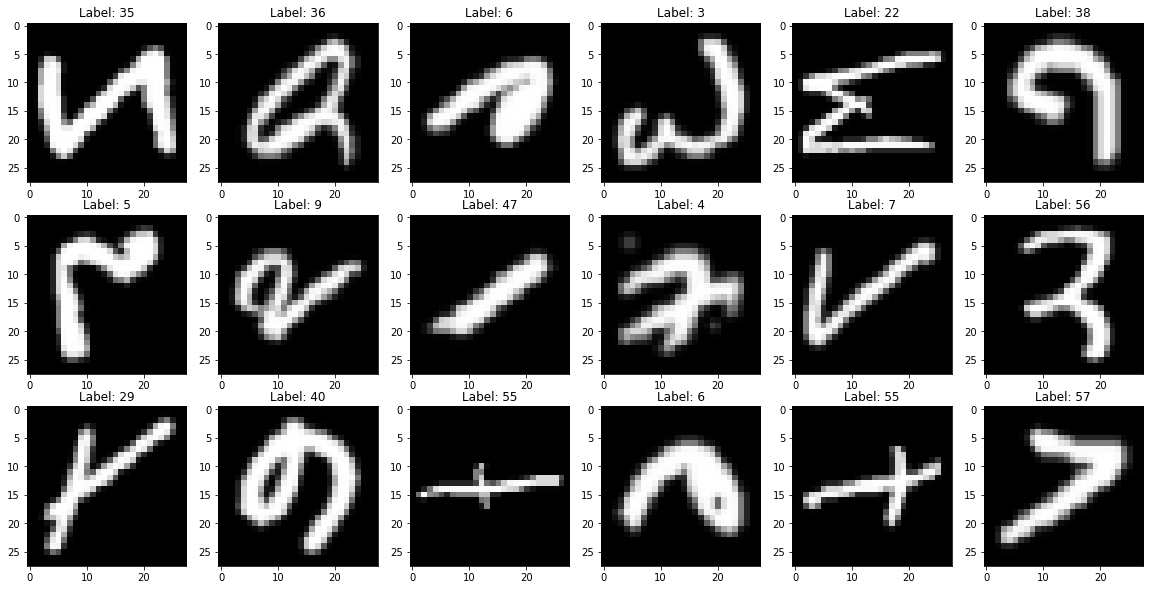

In [22]:
plot_mnist(data=emnist_train)

### 5-1-5. Train-valid split

In [23]:
class mnist_dataset(Dataset):
  def __init__(self, data, targets, transform=None, target_transform=None):
    super().__init__()

    self.data = data
    self.targets = targets
    self.transform = transform
    self.target_transform = target_transform
    pass

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    x, y = self.data[idx], self.targets[idx]

    if self.transform:
      x = self.transform(x)
    if self.target_transform:
      y = self.target_transform(y)

    return x, y

In [24]:
def split_train_valid(dataset, valid_ratio=0.1):
  n_valid = int(len(dataset) * valid_ratio)
  
  train_data = dataset.data[:-n_valid].numpy()
  valid_data = dataset.data[-n_valid:].numpy()
  train_targets = dataset.targets[:-n_valid]
  valid_targets = dataset.targets[-n_valid:]

  train = mnist_dataset(data=train_data, targets=train_targets, transform=dataset.transform, target_transform=dataset.target_transform)
  valid = mnist_dataset(data=valid_data, targets=valid_targets, transform=dataset.transform, target_transform=dataset.target_transform)

  return train, valid

In [25]:
mnist_train, mnist_valid = split_train_valid(dataset=mnist_train)
fmnist_train, fmnist_valid = split_train_valid(dataset=fmnist_train)
kmnist_train, kmnist_valid = split_train_valid(dataset=kmnist_train)
emnist_train, emnist_valid = split_train_valid(dataset=emnist_train) #, valid_ratio=0.05)

In [26]:
mnists = {}
mnists["mnist"] = {"train": mnist_train, "valid": mnist_valid, "test": mnist_test}
mnists["fmnist"] = {"train": fmnist_train, "valid": fmnist_valid, "test": fmnist_test}
mnists["kmnist"] = {"train": kmnist_train, "valid": kmnist_valid, "test": kmnist_test}
mnists["emnist"] = {"train": emnist_train, "valid": emnist_valid, "test": emnist_test}

for k in mnists.keys():
  print(f"Length of {k}: train - {len(mnists[k]['train'])}, valid - {len(mnists[k]['valid'])}, test - {len(mnists[k]['test'])}.")

Length of mnist: train - 54000, valid - 6000, test - 10000.
Length of fmnist: train - 54000, valid - 6000, test - 10000.
Length of kmnist: train - 54000, valid - 6000, test - 10000.
Length of emnist: train - 628139, valid - 69793, test - 116323.


In [27]:
mnists

{'emnist': {'test': Dataset EMNIST
      Number of datapoints: 116323
      Root location: /content/drive/MyDrive/Colab Notebooks/data
      Split: Test
      StandardTransform
  Transform: ToTensor(),
  'train': <__main__.mnist_dataset at 0x7f6676a7ec90>,
  'valid': <__main__.mnist_dataset at 0x7f6676551690>},
 'fmnist': {'test': Dataset FashionMNIST
      Number of datapoints: 10000
      Root location: /content/drive/MyDrive/Colab Notebooks/data
      Split: Test
      StandardTransform
  Transform: ToTensor(),
  'train': <__main__.mnist_dataset at 0x7f6676a5b610>,
  'valid': <__main__.mnist_dataset at 0x7f6675953410>},
 'kmnist': {'test': Dataset KMNIST
      Number of datapoints: 10000
      Root location: /content/drive/MyDrive/Colab Notebooks/data
      Split: Test
      StandardTransform
  Transform: ToTensor(),
  'train': <__main__.mnist_dataset at 0x7f66759536d0>,
  'valid': <__main__.mnist_dataset at 0x7f66759aef10>},
 'mnist': {'test': Dataset MNIST
      Number of datapoin

In [28]:
loaders = {}
for k in mnists.keys():
  loaders[k] = {s: DataLoader(dataset=mnists[k][s], batch_size=512 if k == "emnist" else 64, shuffle= s == "train", drop_last=True) for s in ["train", "valid", "test"]}

In [29]:
loaders

{'emnist': {'test': <torch.utils.data.dataloader.DataLoader at 0x7f6676583550>,
  'train': <torch.utils.data.dataloader.DataLoader at 0x7f6676583810>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f6676583ed0>},
 'fmnist': {'test': <torch.utils.data.dataloader.DataLoader at 0x7f6676583ad0>,
  'train': <torch.utils.data.dataloader.DataLoader at 0x7f6675953850>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f6676583910>},
 'kmnist': {'test': <torch.utils.data.dataloader.DataLoader at 0x7f6676583c90>,
  'train': <torch.utils.data.dataloader.DataLoader at 0x7f6676583b90>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f6676583e90>},
 'mnist': {'test': <torch.utils.data.dataloader.DataLoader at 0x7f6675953550>,
  'train': <torch.utils.data.dataloader.DataLoader at 0x7f6675a49c50>,
  'valid': <torch.utils.data.dataloader.DataLoader at 0x7f6675953110>}}

## 5-2. Model Build


In [30]:
class LionMNISTClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

In [31]:
mlp = LionMNISTClassifier()
mlp

LionMNISTClassifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

## 5-3. Trainer

In [32]:
class Trainer(nn.Module):
  def __init__(self, model_class, loaders, n_class=10, opt="sgd", lr=0.001, has_scheduler=False, device="cpu"):
    super().__init__()

    self.model = model_class(n_class=n_class)
    self.loss = nn.CrossEntropyLoss()
    
    self.train_loader = loaders["train"]
    self.valid_loader = loaders["valid"]
    self.test_loader = loaders["test"]

    self._get_optimizer(opt=opt.lower(), lr=lr)
    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()

    self.device = device
    pass

  def _get_optimizer(self, opt, lr=0.001):
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt == "adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"optimizer {opt} is not supproted")

  def _get_scheduler(self):
    self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)

  def train(self, max_epochs=10):
    print("===== Train Start =====")
    history = {"train_loss": [], "train_acc": [], "valid_loss": [], "valid_acc": []}
    for e in range(max_epochs):
      train_loss, train_acc = self._train_epoch()
      valid_loss, valid_acc = self._valid_epoch()

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["valid_loss"].append(valid_loss)
      history["valid_acc"].append(valid_acc)

      if self.has_scheduler:
        self.scheduler.step()

      if e % 5 == 0:
        print(f"Epoch: {e}, train loss: {train_loss:>6f}, train acc: {train_acc:>3f}, valid loss: {valid_loss:>6f}, valid acc: {valid_acc:>3f}")

    self.plot_history(history)

  def _train_epoch(self):
    epoch_loss, epoch_acc = 0, 0
    self.model.train()
    for (x, y) in self.train_loader:
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)
      loss = self.loss(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      epoch_loss += loss.to("cpu").item()
      epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.train_loader)
    epoch_acc /= len(self.train_loader)

    return epoch_loss, epoch_acc
  
  def _valid_epoch(self):
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in self.valid_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.valid_loader)
    epoch_acc /= len(self.valid_loader)

    return epoch_loss, epoch_acc

  def plot_history(self, history):
    fig = plt.figure(figsize=(20, 10))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    fig.show()

  def test(self):
    print("===== Test Start =====")
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    with torch.no_grad():
      for (x, y) in self.test_loader:
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(1) == y).type(torch.float).to("cpu").mean().item()

    epoch_loss /= len(self.test_loader)
    epoch_acc /= len(self.test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}")

===== Train Start =====
Epoch: 0, train loss: 2.296373, train acc: 0.124055, valid loss: 2.282129, valid acc: 0.163978
Epoch: 5, train loss: 1.905805, train acc: 0.649374, valid loss: 1.784209, valid acc: 0.704973
Epoch: 10, train loss: 0.874488, train acc: 0.787533, valid loss: 0.762023, valid acc: 0.826949
Epoch: 15, train loss: 0.578731, train acc: 0.846030, valid loss: 0.488588, valid acc: 0.882897
Epoch: 20, train loss: 0.468496, train acc: 0.872201, valid loss: 0.388143, valid acc: 0.901714
Epoch: 25, train loss: 0.412472, train acc: 0.885046, valid loss: 0.338671, valid acc: 0.910786
Epoch: 30, train loss: 0.379005, train acc: 0.893702, valid loss: 0.309968, valid acc: 0.914987
Epoch: 35, train loss: 0.355747, train acc: 0.899336, valid loss: 0.291619, valid acc: 0.918515
Epoch: 40, train loss: 0.338679, train acc: 0.903321, valid loss: 0.277084, valid acc: 0.922379
Epoch: 45, train loss: 0.324913, train acc: 0.907028, valid loss: 0.266018, valid acc: 0.924227
===== Test Start =

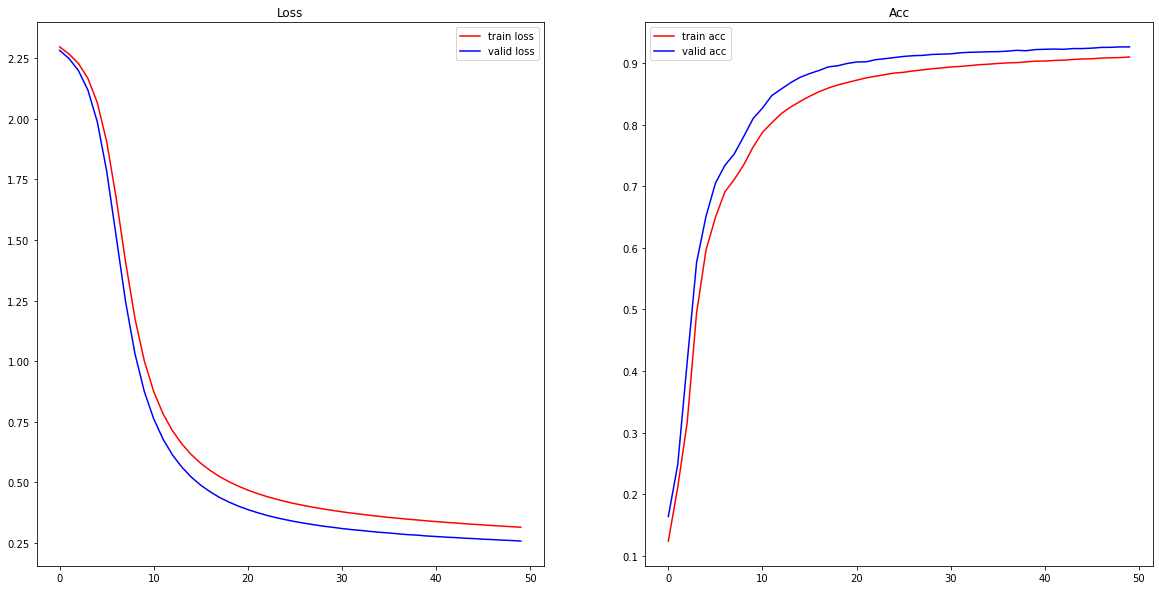

In [33]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders["mnist"], n_class=10, opt="sgd", lr=0.001, device=device).to(device)
trainer.train(max_epochs=50)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.305968, train acc: 0.912904, valid loss: 0.115655, valid acc: 0.967406
Epoch: 5, train loss: 0.031887, train acc: 0.989880, valid loss: 0.084959, valid acc: 0.976310
Epoch: 10, train loss: 0.014646, train acc: 0.994884, valid loss: 0.107226, valid acc: 0.976647
Epoch: 15, train loss: 0.009740, train acc: 0.996701, valid loss: 0.112700, valid acc: 0.977487
Epoch: 20, train loss: 0.008055, train acc: 0.997257, valid loss: 0.117246, valid acc: 0.981687
Epoch: 25, train loss: 0.003221, train acc: 0.999092, valid loss: 0.153196, valid acc: 0.980175
===== Test Start =====
Test loss: 0.111073, Test acc: 0.981070


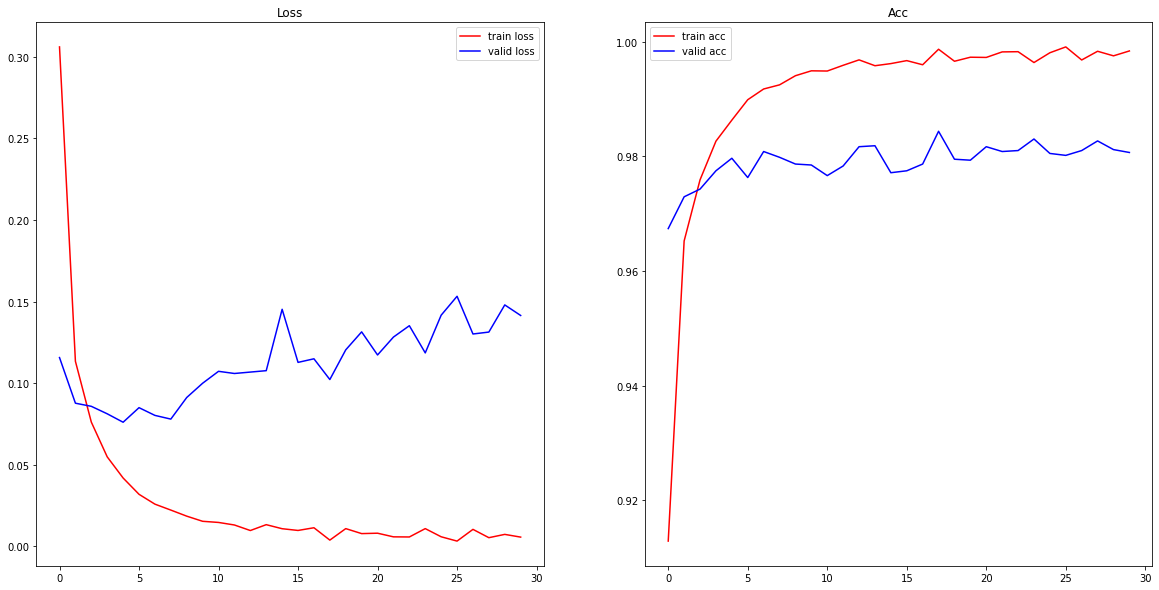

In [34]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders["mnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

Adjusting learning rate of group 0 to 1.0000e-03.
===== Train Start =====
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch: 0, train loss: 0.299606, train acc: 0.913386, valid loss: 0.119819, valid acc: 0.964550
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch: 5, train loss: 0.019288, train acc: 0.994532, valid loss: 0.064197, valid acc: 0.982527
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 5.0000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch: 10, train loss: 0.003292, train acc: 0.999425, valid loss: 0.076086, valid acc: 0.982863
Adjusting learning rate of group 0 to 2.5000e-04.
Adjusting learning rate of group 0 to 2.

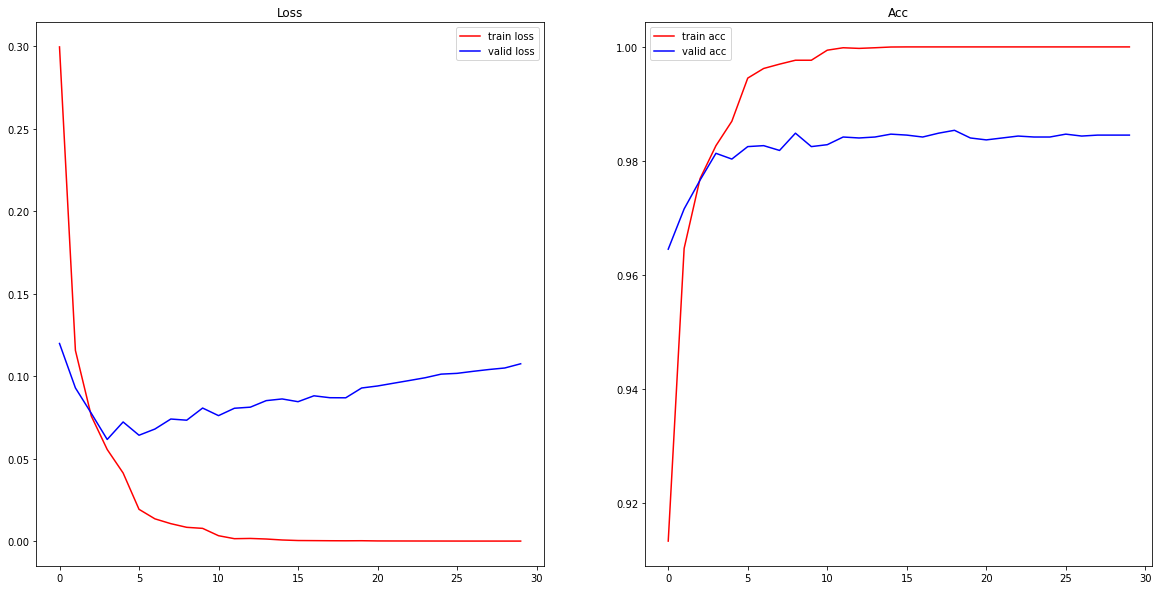

In [35]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders["mnist"], n_class=10, opt="adam", lr=0.001, has_scheduler=True, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.535636, train acc: 0.808478, valid loss: 0.438737, valid acc: 0.842910
Epoch: 5, train loss: 0.275679, train acc: 0.897483, valid loss: 0.348125, valid acc: 0.878528
Epoch: 10, train loss: 0.221063, train acc: 0.915555, valid loss: 0.361366, valid acc: 0.880712
Epoch: 15, train loss: 0.181351, train acc: 0.931272, valid loss: 0.365815, valid acc: 0.887097
Epoch: 20, train loss: 0.153935, train acc: 0.940688, valid loss: 0.384316, valid acc: 0.888105
Epoch: 25, train loss: 0.131572, train acc: 0.949437, valid loss: 0.406608, valid acc: 0.891297
===== Test Start =====
Test loss: 0.452775, Test acc: 0.887520


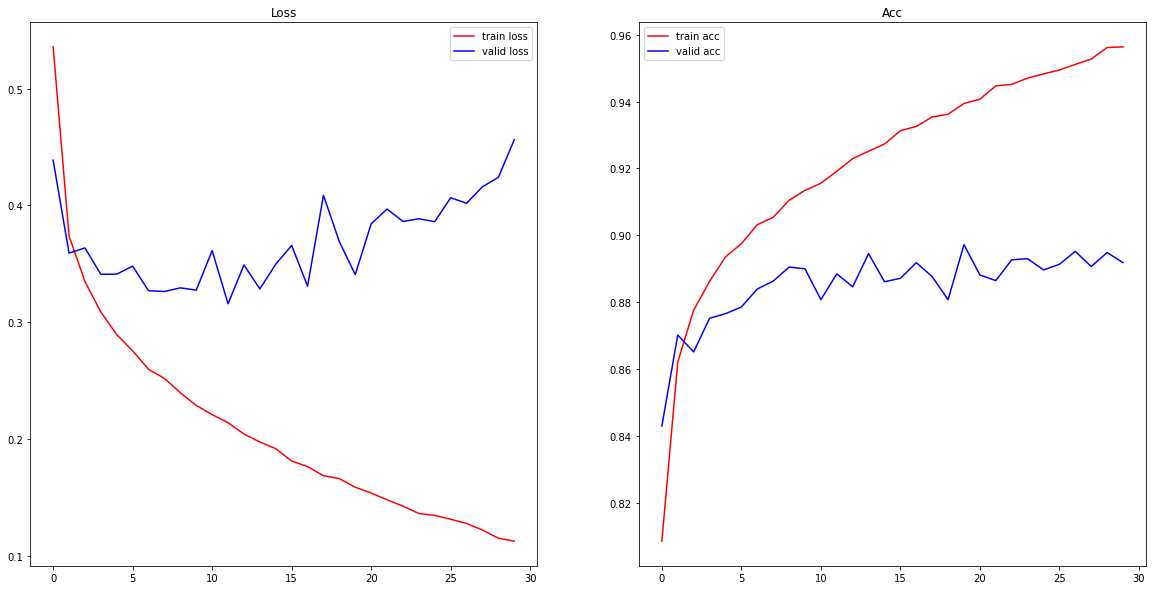

In [36]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.455645, train acc: 0.861636, valid loss: 0.263247, valid acc: 0.916499
Epoch: 5, train loss: 0.043770, train acc: 0.986099, valid loss: 0.161385, valid acc: 0.955981
Epoch: 10, train loss: 0.021279, train acc: 0.992845, valid loss: 0.205861, valid acc: 0.958501
Epoch: 15, train loss: 0.015024, train acc: 0.995218, valid loss: 0.231151, valid acc: 0.961022
Epoch: 20, train loss: 0.014012, train acc: 0.995533, valid loss: 0.265618, valid acc: 0.956821
Epoch: 25, train loss: 0.006875, train acc: 0.997776, valid loss: 0.286726, valid acc: 0.960181
===== Test Start =====
Test loss: 0.791075, Test acc: 0.910256


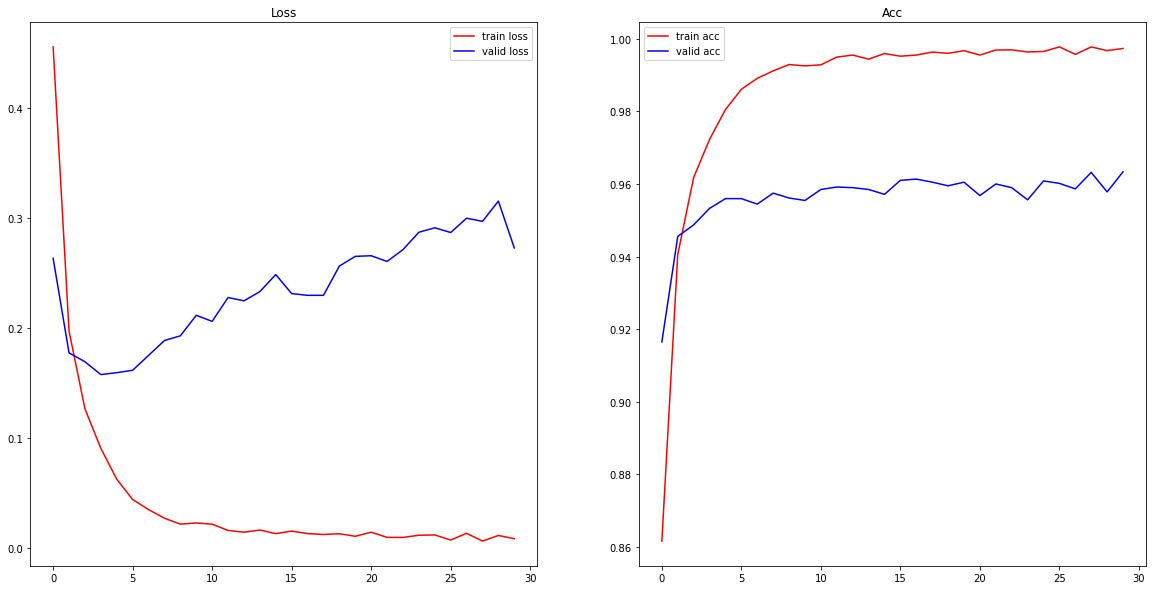

In [37]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders["kmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.884726, train acc: 0.742074, valid loss: 0.606300, valid acc: 0.801700
===== Test Start =====
Test loss: 0.447524, Test acc: 0.843105


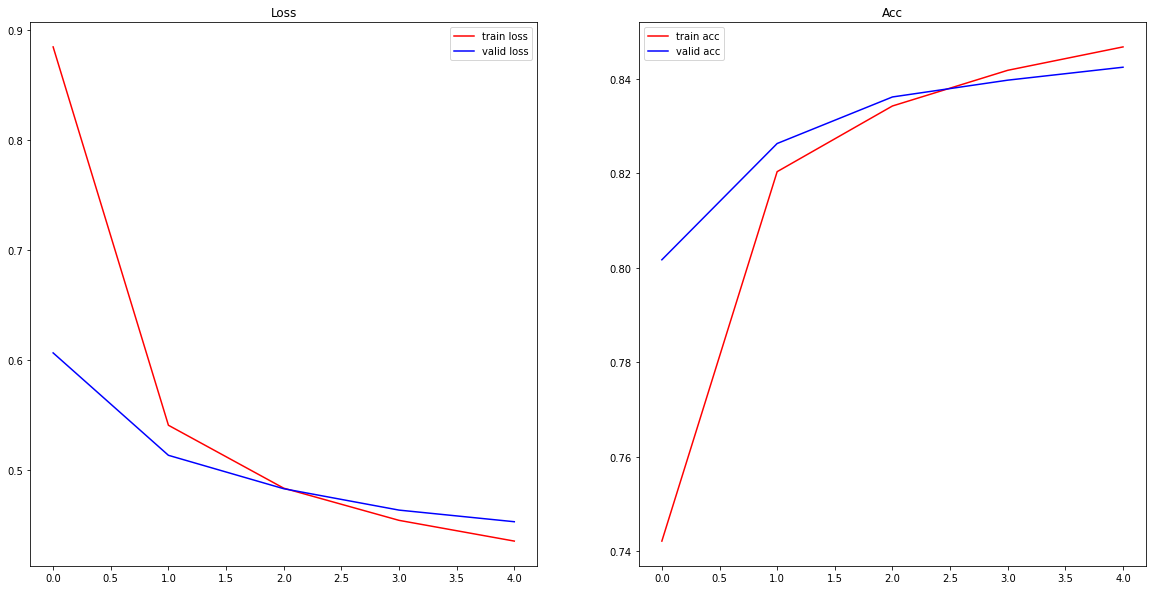

In [39]:
trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders["emnist"], n_class=62, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=5)
trainer.test()

In [ ]:
table = {"mnist": 10, "fmnist": 10, "kmnist": 10, "emnist": 62}
for d_name in ["mnist", "fmnist", "kmnist", "emnist"]:
  print(f"Start short training dataset {d_name} with adam optimizer")
  trainer = Trainer(model_class=LionMNISTClassifier, loaders=loaders[d_name], n_class=table[d_name], opt="adam", lr=0.001, device=device).to(device)
  trainer.train(max_epochs = 15 if d_name != "emnist" else 5)
  trainer.test()

## 5-4. Model with dropout and batch normalization

In [40]:
class LionMNISTDropoutClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class LionMNISTBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

class LionMNISTDropoutBNClassifier(nn.Module):
  def __init__(self, n_class=10):
    super().__init__()

    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.BatchNorm1d(256),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(128, n_class),
    )

  def forward(self, x):
    return self.model(x)

===== Train Start =====
Epoch: 0, train loss: 0.705515, train acc: 0.741937, valid loss: 0.439061, valid acc: 0.834005
Epoch: 5, train loss: 0.405425, train acc: 0.854111, valid loss: 0.357597, valid acc: 0.862735
Epoch: 10, train loss: 0.368993, train acc: 0.865288, valid loss: 0.333057, valid acc: 0.880544
Epoch: 15, train loss: 0.346971, train acc: 0.873480, valid loss: 0.320911, valid acc: 0.881720
Epoch: 20, train loss: 0.331978, train acc: 0.877502, valid loss: 0.318994, valid acc: 0.882560
Epoch: 25, train loss: 0.319411, train acc: 0.882859, valid loss: 0.305168, valid acc: 0.886929
===== Test Start =====
Test loss: 0.344581, Test acc: 0.875801


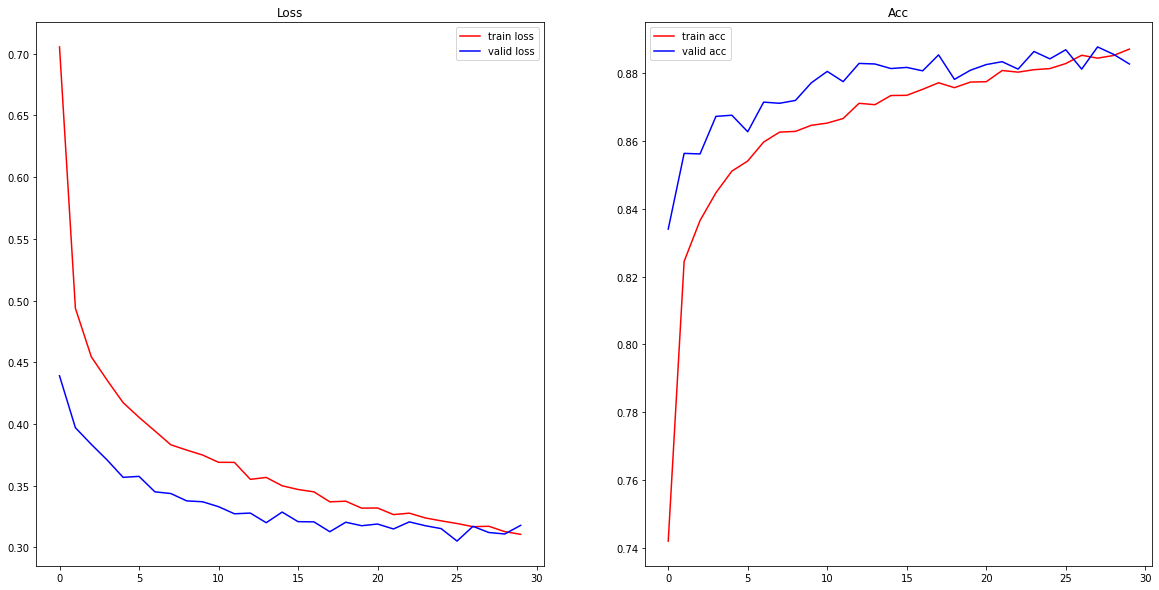

In [41]:
trainer = Trainer(model_class=LionMNISTDropoutClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.458018, train acc: 0.839728, valid loss: 0.396046, valid acc: 0.851142
Epoch: 5, train loss: 0.236719, train acc: 0.912385, valid loss: 0.318600, valid acc: 0.883569
Epoch: 10, train loss: 0.174938, train acc: 0.935035, valid loss: 0.348345, valid acc: 0.883401
Epoch: 15, train loss: 0.130511, train acc: 0.950697, valid loss: 0.385038, valid acc: 0.884745
Epoch: 20, train loss: 0.103740, train acc: 0.960483, valid loss: 0.376512, valid acc: 0.890457
Epoch: 25, train loss: 0.081065, train acc: 0.969788, valid loss: 0.434465, valid acc: 0.891969
===== Test Start =====
Test loss: 0.453823, Test acc: 0.890425


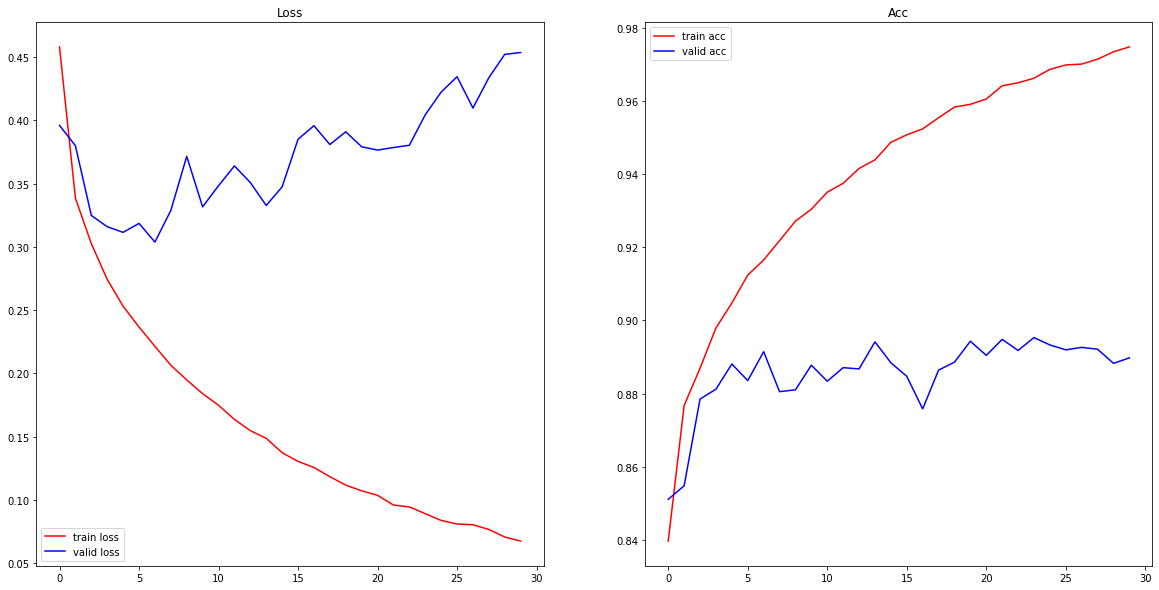

In [42]:
trainer = Trainer(model_class=LionMNISTBNClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()

===== Train Start =====
Epoch: 0, train loss: 0.627820, train acc: 0.784920, valid loss: 0.399230, valid acc: 0.852487
Epoch: 5, train loss: 0.386188, train acc: 0.862266, valid loss: 0.322557, valid acc: 0.880712
Epoch: 10, train loss: 0.341080, train acc: 0.876687, valid loss: 0.306735, valid acc: 0.886425
Epoch: 15, train loss: 0.318224, train acc: 0.883192, valid loss: 0.298411, valid acc: 0.889617
Epoch: 20, train loss: 0.296334, train acc: 0.891848, valid loss: 0.296974, valid acc: 0.894321
Epoch: 25, train loss: 0.282226, train acc: 0.897372, valid loss: 0.297317, valid acc: 0.890289
===== Test Start =====
Test loss: 0.306664, Test acc: 0.892228


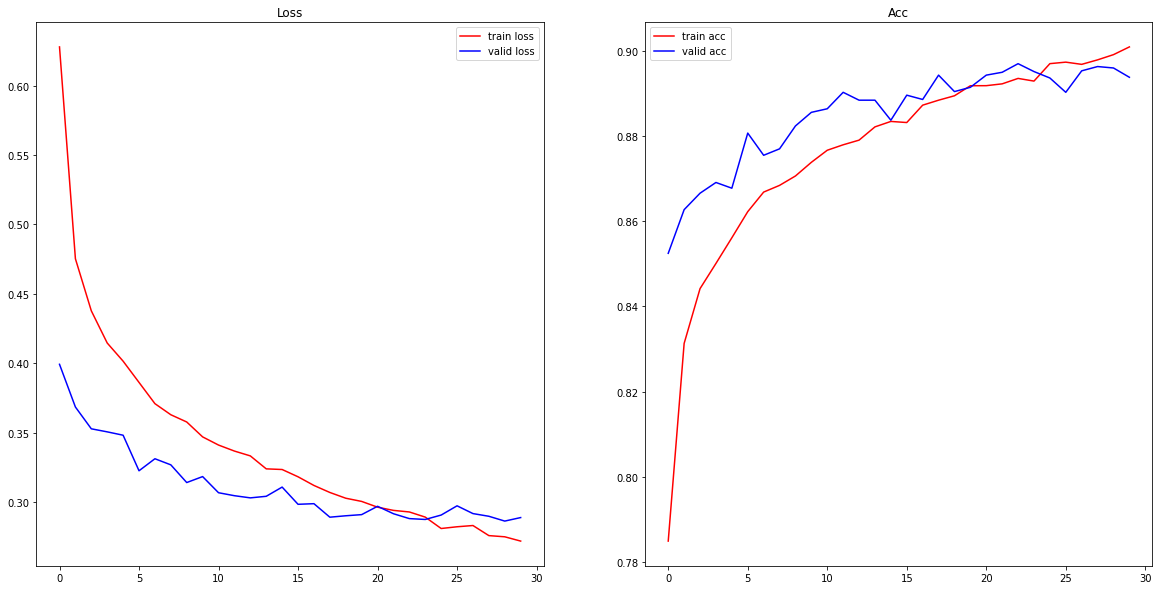

In [43]:
trainer = Trainer(model_class=LionMNISTDropoutBNClassifier, loaders=loaders["fmnist"], n_class=10, opt="adam", lr=0.001, device=device).to(device)
trainer.train(max_epochs=30)
trainer.test()